# "Closed Form" Equations

Directly computing the model parameters that best fit the model to the training set.

## Linear Regression

Find the thetas / betas / llinear regression parameters that minimizes the RMSE (Root Mean Squared Error).

Be aware that there is the concept of loss function, which is used during training, and can be a different performance measure used to evaluate the final model. For example, classifiers are often traind using a cost function such as the log loss, but evaluated using precision/recall!

In [ ]:
import numpy as np

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m,1) # 100 rows, 1 column
y = 4 + 3 * X + np.random.randn(m,1)

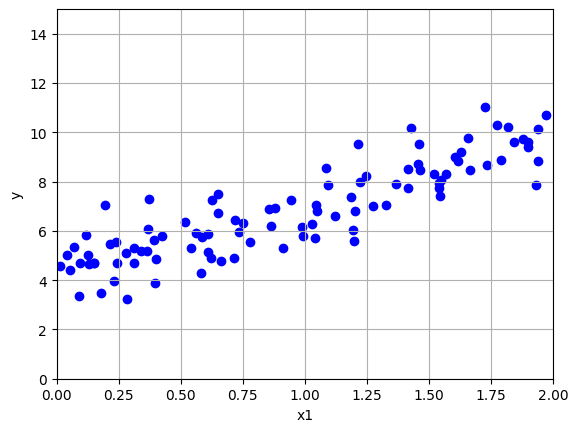

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X,y, c="blue")
plt.grid()
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(0,2)
plt.ylim(0,15)
plt.show()

In [ ]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
# The operator @ performs the matrix multiplication
# same as np.matmul()
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [ ]:
# Observe how the intercept and gradient is not necessarily 4 and 3
# which was what we defined in our model
theta_best

array([[4.21509616],
       [2.77011339]])

In [8]:
X_new = np.array([[0],[2]])
X_new_b = add_dummy_feature(X_new) # Add X0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

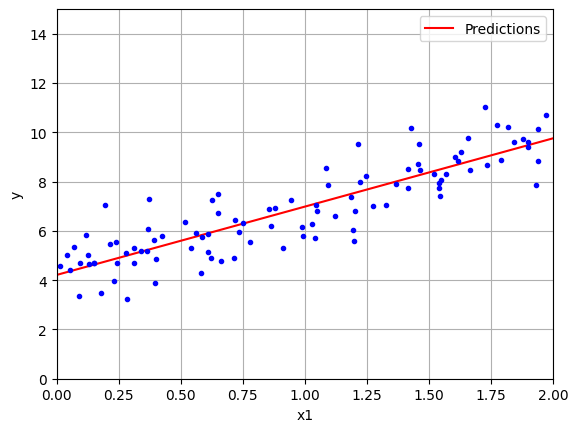

In [10]:
plt.plot(X_new, y_predict, "r-", label = "Predictions")
plt.plot(X,y,"b.")
plt.grid()
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(0,2)
plt.ylim(0,15)
plt.legend()
plt.show()

In [11]:
# using sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [ ]:
# directly calling the thetas using np.linalg.lstsq
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [ ]:
# Can also directly compute the pesudoinverse
# Specifically the Moore-Penrose inverse
# Computed using a standard matrix factorization called SVD
# Decomposing the training set matrix X into the matrix multiplication
# of U Sigma V_transpose
# Where X+ = V Sigma+ U_transpose
np.linalg.pinv(X_b)@ y

array([[4.21509616],
       [2.77011339]])

### Computational Complexity

Note that computing the normal inverse of X_transpose @ X has the complexity of O(n^2.4) to O(n^3). Meanwhile the SVD approach complexity is only O(n^2).

Though note that prediction are very fast.

# Gradient Descent (GD)

Gradually tweaking model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters, as the first method. Variations include batch GD, mini-batch GD and stochastic GD

When using Gradient Descent, ensure that all features have a similar scale! Else it will take much longer to converge.

## Batch Gradient Descent

As it calculates over the full training set X, the algorithm is very slow on very large training sets. However, this algorithm scales well with the number of features, <br> i.e. **using gradient descent for linear regression is faster when there are hundreds of thousands of features compared to using Normal equation / SVD decomposition**

In [16]:
eta = 0.1 # learning rate
n_epochs = 1000
m = len(X_b) # number of instances

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = 2/m * X_b.T @(X_b @ theta-y) # (2 x n) [(nx2) * (2x1) - (nx1)]
    # for theta 0, it will just be the sum of (X_b * theta_0) - y
    # for theta 1, it will be the sum of X_b_i * [(X_b_i * theta_1)-yi]
    # for i = 1 - 100
    theta = theta - eta * gradients

In [17]:
theta

array([[4.21509616],
       [2.77011339]])

## Stochastic Gradient Descent

Picking random instances in the training set at every step, and computes the gradients based only on that single instance.

While faster than batch gradient descent, the algorithm is much less regular than batch gradient descent, aka the cost function will bounce up and down, decreasing only on average. Hence, when the algorithm stops, the final parameter values will be good, but not optimal.

Though in theory, it has a better chance of finding the GLOBAL minimum than batch gradient descent does.

We overcome the issue of Stochastic GD not settling down to a minimum by gradually reducing the learning rate. But then the problem also becomes, how quickly should we reduce the learning rate.

In [18]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for iteration in range(m): # m = 100
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

In [19]:
theta

array([[4.21076011],
       [2.74856079]])

When using Stochastic GD, the training instances MUST be independent AND identically distirbuted (IID) to ensure that the parameters get pulled toward the global optimum, on average. This is done by shuffling the instances during training.

In [ ]:
# using stochastic GD in linear regression
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, # maximum epochs
                       tol = 1e-5, #tolerance level during n_iter_no_change
                       penalty = None, #uses no regularization
                       eta0 = 0.01, # learning rate
                       n_iter_no_change=100,
                       random_state=42)
sgd_reg.fit(X, y.ravel()) #y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Mini-Batch Gradient Descent

In between batch & stochastic GD where during each iteration, we compute the gradient on small random sets of instances.
While this means that it will be faster that stochastic GD, it will end up walking around a bit closer to the minimum and ma be harder to escape from a local minimum.

# Polynomial Regression

Adding powers of each feature as new features and then training a linear model on this extended sets of features.

and how to detect when the model is overfitted to the training data.

In [22]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m,1)

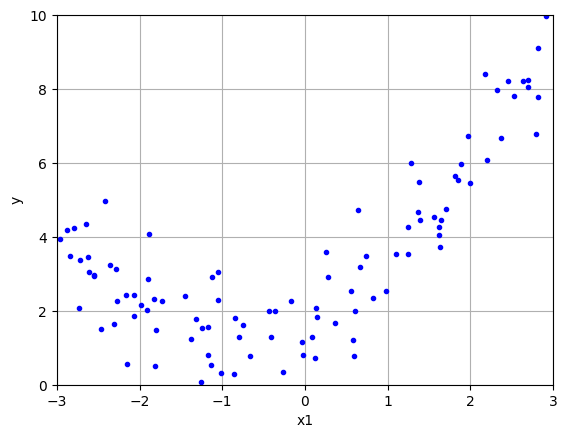

In [23]:
plt.plot(X,y,"b.")
plt.grid()
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(-3,3)
plt.ylim(0,10)
plt.show()

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)

In [25]:
X[0]

array([-0.75275929])

In [26]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [34]:
X_new = np.linspace(-3,3,100).reshape(-1,1)
X_new_poly = poly_features.fit_transform(X_new)
y_predict = lin_reg.predict(X_new_poly)

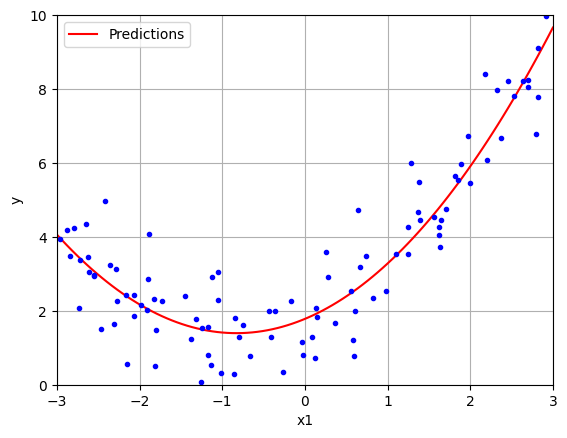

In [35]:
plt.plot(X_new, y_predict, "r-", label = "Predictions")
plt.plot(X,y,"b.")
plt.grid()
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(-3,3)
plt.ylim(0,10)
plt.legend()
plt.show()

# Learning Curves

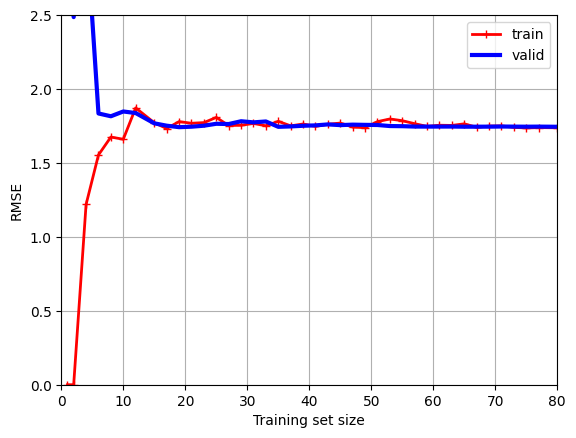

In [38]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
    scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis = 1)

plt.plot(train_sizes, train_errors, "r-+", linewidth = 2, label = "train")
plt.plot(train_sizes, valid_errors, "b-", linewidth = 3, label = "valid")
plt.grid()
plt.legend()
plt.xlim(0,80)
plt.ylim(0,2.5)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

The curve shows an underfitting model as both the validation and train error hits a plateu and is unable to further improve, in addition, the closeness between training and valid curve during the plateu also serves as a sign of underfitting (aka generalized badly for both training and validatino)

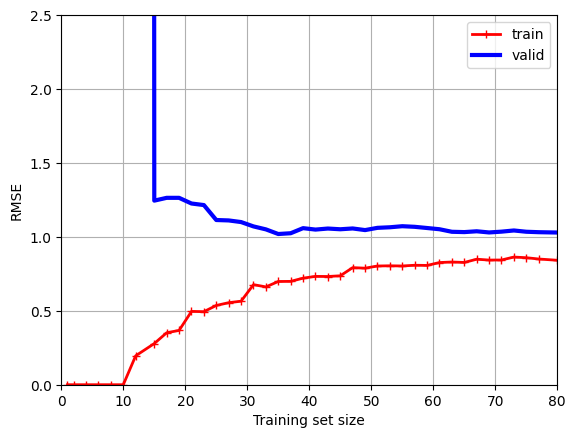

In [ ]:
# degree 10
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree = 10, include_bias=False),
    LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
    scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis = 1)

plt.plot(train_sizes, train_errors, "r-+", linewidth = 2, label = "train")
plt.plot(train_sizes, valid_errors, "b-", linewidth = 3, label = "valid")
plt.grid()
plt.legend()
plt.xlim(0,80)
plt.ylim(0,2.5)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

This curve shows a overfit model where there is a gap between the curve, meaning that the model is doing well on the trianing but not so much on the validation.

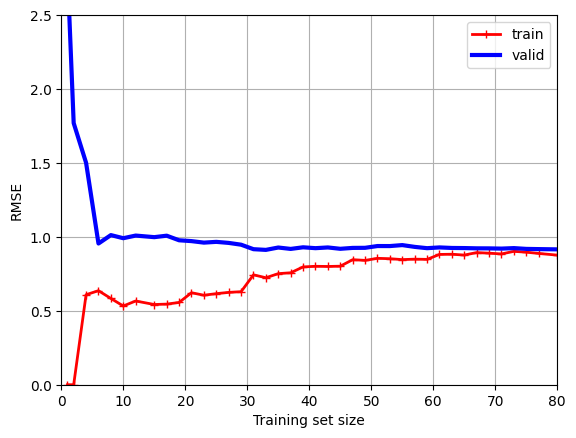

In [40]:
# degree 2
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree = 2, include_bias=False),
    LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
    scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis = 1)

plt.plot(train_sizes, train_errors, "r-+", linewidth = 2, label = "train")
plt.plot(train_sizes, valid_errors, "b-", linewidth = 3, label = "valid")
plt.grid()
plt.legend()
plt.xlim(0,80)
plt.ylim(0,2.5)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

# Regularized Linear Models

Be mindful that the regularization in the RMSE is only done for during the training and not during the evaluation of the model's performance.

Also, the intercept IS NOT regularized too.

Also, perform the standard scaler when performing regularized linear model, remember the problem set you did to prove this.

## Ridge Regression

In [43]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([4.82899748])

In [44]:
sgd_reg = SGDRegressor(penalty = "l2", alpha = 0.1 / m, tol = None,
                       max_iter = 1000, eta0 = 0.01, random_state = 42)

sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.82830117])

## Lasso Regression

Least absolute shrinkage and selection opeartor regression.

Like ridge, but using the l1 norm.

Lasso tends to eliminate the weights of the least important features (set to zero).

In [46]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha  = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

## Elastic Net Regression

Middle ground between ridge and lasso regression.
The regularization term is a weighted sum of both ridge and lasso's regularization terms, and the ratio can be controlled using r.

- when r = 0, it is the same as ridge regression.
- when r = 1, it is the same as lasso

In general, elastic net is preferred over lasso because lasso may behaver erratically when the number of features > number of training instances OR when several features are strongly correlated.

In [47]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

## Early Stopping

Stop the algorithm training just as soon as the validation error reaches the minimum.

In [49]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, y_train, X_valid, y_valid = X[0:80], y[0:80], X[80:], y[80:]

preprocessing = make_pipeline(PolynomialFeatures(degree = 90, include_bias = False),
                              StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid) # use the fitted values from X_train

sgd_reg = SGDRegressor(penalty=None, eta0 = 0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float("inf")

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train.ravel())
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)


# Logistic Regression

The score t in logistics regression is called the *logit* and is also called the *log-odds*, as it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class.

In [56]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame = True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [57]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [58]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int64

In [59]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test , y_train, y_test = train_test_split(X, y, random_state = 42)

log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

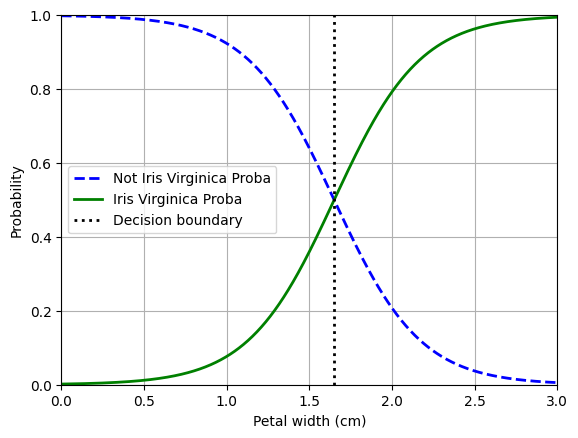

In [65]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1] > 0.5][0,0]

plt.plot(X_new, y_proba[:,0], "b--", linewidth=2, label ="Not Iris Virginica Proba")
plt.plot(X_new, y_proba[:,1], "g-", linewidth=2, label ="Iris Virginica Proba")
plt.plot([decision_boundary, decision_boundary], [0,1], "k:", linewidth=2,
         label="Decision boundary")
plt.grid()
plt.legend()
plt.xlim(0,3)
plt.ylim(0,1)
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.show()




## Softmax Regression / Multinomial Logistic Regression

Use the cross entropy cost function to train the model as it penalizes the model when it estimates a low probability for a target class.



In [66]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C = 30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [67]:
softmax_reg.predict([[5,2]])

array([2])

In [68]:
softmax_reg.predict_proba([[5,2]]).round(2)

array([[0.  , 0.04, 0.96]])

# Exercises

## 1. Which linear regression training algorithm can be used if we have a training set with millions of features?

Use the Stochastic GD or Mini-batch GD, and maybe even Batch GD if the training set fits in the memory.

## 2. Suppose the features in the training set have very different scales, which algorithm will sufer and how? What can you do about it?

Gradient Descent algorithms will have the shape of an elongated bowl and wiill take longer to converge. We can overcome this be using the StandardScaler function to standardize each of the column in the training dataset.

## 3 Can gradient descent get stuck in a local minimum when training a logistic regression model?

Since the cost function of a logistic regression model is convex when looking from an MLE standpoint. So most likely no, GD will NOT get stuck in a local minimum.

## 4. Do all gradient descent lead to the same model, provided you let them run enough?


I believe so, but with the caveat of the proper learning rate.

## 5. Suppose batch GD is used and the validation error is plotted at every epoch. If the validation error consistently goes up, then what is happening and how can it be fixed?

If the training error is going up as well, then most likely the learning rate is too big, and we can fix this by decreasing the learning rate.

If the training error is not going up, then the model is overfit to the training set and should stop the training.

## 6. Is it a good idea to stop mini-batch GD immediately when the validation error goes up?

no, because it may be getting out of a local minima, so we should have a cap on the amount of time that it is above the minimum to all for this opportunity to occur.

## 7. Which GD algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge and how can you make the other converge as well?

The stochastic GD will reach the optimal solution the fastest as it only considers 1 training instances at a time. <br>

Only batch GD will actually converge, but will take a long time.

## 8. Suppose you are using polynomial regression and you plot the learning curve and notice that there is a large gap between training and validation error. What is happening and give 3 ways to solve this.

The model most likely is overfitted to the training set, the following methods can be done to correct this issue

1. Decrease the degree of the polynomial;
2. Leverage the use of ridge / lasso regression during polynomial regression
3. Feed more training data!

## 9. Suppose you are using ridge regression and notice that the training error and validation error are almost equal and fairly high. Would you say the model suffers from high bias or high variance? Should you increase the regularization hyperparameter alfa or reduce?

I think this will mean that the model suffers from high bias, and hence decreasing the regularization hyperparameter can help in selecting feature that are more reflective of the model.

## 10. Why would you want to use: 
- Ridge regresssion over plain linear regression?  <br?>
When you want to perform feature selection but believe that each feature has an effect to the final outcome but to varying degrees


- Lasso instead of ridge regression? <br>
When you wan to perform feature selection and believe that the outcome is only dependent on certain features.

- Elastic net instead of lasso? <br>
When you want to perform feature selection and the number of feature is many times more than the number of training data, or when you believe that certain features are strongly correlated.

# 11. Suppose we want to classify pictures as outdoor / indoor and daytime / nighttime. Should you implement 2 logistics regression or one softmax regression classifier?

2 logistics regression since softmax regression cannot do multioutput regression, and only do multi class regression!

## 12. Implement batch gradient descent with early stopping for softmax regression WITHOUT using scikit-learn, only NumPy and use it on a classification task such as the iris dataset.

In [524]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame = True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [525]:
# initialize variables
eta = 0.5
n_epochs = 1000
best_valid_loss = float("inf") # set initial loss value
epsilon = 1e-5

X = iris.data.values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_b = add_dummy_feature(X_train)
X_test_b = add_dummy_feature(X_test)
# theta should be no_of_covariates + intercept x no_of_classes matrix, in this case 4 x 3
# since there are 4 covariates and 3 different classes
np.random.seed(42)
theta_softmax = np.random.randn(5,3) # 1+p covariates X K classes

In [526]:
# Create the class_matrix for y_train
class_matrix_train = np.zeros((len(y_train), y_train.nunique()), dtype=int)

for i in range(0,3):
    idx = 0
    for j in y_train:
        if j == i:
            class_matrix_train[idx, i] = 1
        idx += 1

In [527]:
# Create the class_matrix for y_test
class_matrix_test = np.zeros((len(y_test), y_test.nunique()), dtype=int)

for i in range(0,3):
    idx = 0
    for j in y_test:
        if j == i:
            class_matrix_test[idx, i] = 1
        idx += 1

In [528]:
# create the exponential (theta * X)
def prob_mat (mat, theta): # returns a matrix
    # N x K class, hence we want X matrix times the theta matrix
    matrix = np.exp(np.matmul(mat, theta))
    return matrix

prob_matrix = prob_mat(X_train_b, theta_softmax)
stand_prob_matrix = np.divide(prob_matrix, np.sum(prob_matrix, axis = 1).reshape(112,1))

np.sum(class_matrix_train * np.log(stand_prob_matrix))

np.float64(-1816.4207660905063)

In [529]:
# Create the cross entropy loss calculation
def cross_entropy_loss_calc (mat, theta, class_matrix, epsilon):
    p_matrix = prob_mat(mat, theta)
    stand_p_matrix = np.divide(p_matrix,np.sum(p_matrix, axis = 1).reshape(len(mat),1))
    ce_loss = np.sum(class_matrix * np.log(stand_p_matrix+epsilon)) * -1/len(class_matrix)
    return ce_loss

In [530]:
# test the function
cross_entropy_loss_calc(X_train_b, theta_softmax, class_matrix_train, epsilon)

np.float64(7.9148714172403)

In [531]:
m = len(X_train_b)
for epoch in range(n_epochs):
    prob_matrix = prob_mat(X_train_b, theta_softmax)
    stand_prob_matrix = np.divide(prob_matrix, np.sum(prob_matrix, axis = 1).reshape(len(X_train_b),1))
    # compute the cross entropy gradient, size should be (1+p covariates x K class)
    gradients = -1/m * X_train_b.T @ (class_matrix_train - stand_prob_matrix)
    # (5 x 112) * (112 x 3 - 112 x 3)
    val_error = cross_entropy_loss_calc(X_test_b, theta_softmax, class_matrix_test, epsilon)
    print(f"epoch {epoch}: {val_error}")
    if val_error < best_valid_loss:
        best_valid_loss = val_error
    theta_softmax = theta_softmax - eta * gradients

epoch 0: 6.968296275250234
epoch 1: 4.5417730886545264
epoch 2: 5.21339339545119
epoch 3: 3.992792766501766
epoch 4: 4.749445716552906
epoch 5: 5.595638361705485
epoch 6: 4.9050442477891805
epoch 7: 4.810382263381434
epoch 8: 3.270347062571939
epoch 9: 4.849822383302003
epoch 10: 3.308971046392387
epoch 11: 2.1605615348532154
epoch 12: 3.3333384964480053
epoch 13: 1.8497548844737257
epoch 14: 3.341173140191329
epoch 15: 0.7833265477109039
epoch 16: 3.3388944159386855
epoch 17: 0.9363833816912588
epoch 18: 3.339512688249792
epoch 19: 0.5851368535682944
epoch 20: 3.3305312675111858
epoch 21: 1.4976110936323699
epoch 22: 3.3357934811399432
epoch 23: 0.4627946880149994
epoch 24: 3.288774140894955
epoch 25: 2.32344883912196
epoch 26: 3.331878024095935
epoch 27: 0.7844396827734356
epoch 28: 3.331537453902573
epoch 29: 0.7829640171826064
epoch 30: 3.331412410451117
epoch 31: 0.7136262509775345
epoch 32: 3.329578328177169
epoch 33: 0.8773324131982709
epoch 34: 3.331399913643884
epoch 35: 0.546

In [532]:
best_valid_loss

np.float64(0.02674473015992026)

In [ ]:
# compute the probability for the X_test
prob_test_matrix = prob_mat(X_test_b, theta_softmax)
stand_prob_test_matrix = np.divide(prob_test_matrix, np.sum(prob_test_matrix, axis = 1).reshape(len(X_test_b),1))

In [534]:
y_pred_manual = np.zeros((38,1))
idx = 0
for i in stand_prob_test_matrix:
    y_pred_manual[idx] = i.argmax()
    idx +=1

In [535]:
y_pred_manual

array([[1.],
       [0.],
       [2.],
       [1.],
       [1.],
       [0.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [2.],
       [1.],
       [0.]])

In [536]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_manual)

1.0

Using batch GD, we managed to iterate until the accuracy is 100%!

Compare the result with actualy softmax_reg implementation

In [254]:
# Using softmax function in sklearn for comparison
softmax_reg = LogisticRegression(C = 0.1, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
y_test_pred = softmax_reg.predict(X_test)
accuracy_score(y_test, y_test_pred)

1.0

## Answer from textbook

In [483]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

In [484]:
# add bias
# https://numpy.org/doc/2.2/reference/generated/numpy.c_.html
X_with_bias = np.c_[np.ones(len(X)), X]

In [485]:
test_ratio = 0.2 # 20% for test
validation_ratio = 0.2 # 20% for validation
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [486]:
# Converting the vector of class indices into a matrix containing
# a one-hot vector for each instance.
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

In [487]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [488]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [489]:
# Create the one hot encodig for all Ys
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [490]:
# SCALE THE INPUTS!
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

In [491]:
# implement the Softmax function
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

In [492]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

In [493]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830647
2000 0.1301309575504088
3000 0.12009639326384534
4000 0.11372961364786881
5000 0.11002459532472422


In [494]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [495]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9333333333333333)

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [496]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        # definition of l2_loss
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        # add the l2_loss * alpha (or lambda in most textbooks)
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    # Modify the gradient to also include the alpha * theta terms
    # think of how we are differentiating the l2 loss as well
    # when computing the gradient!
    # the code below just concatenates a column vector for the intercept
    # and the alpha * theta for non-intercept terms
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


In [497]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9333333333333333)

In [ ]:
# This time we change the reguralization hyperparameter AND
# Implement early stopping
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.inf

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        # immediately stop when the total_loss is higher than the recorded best loss
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [500]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9333333333333333)

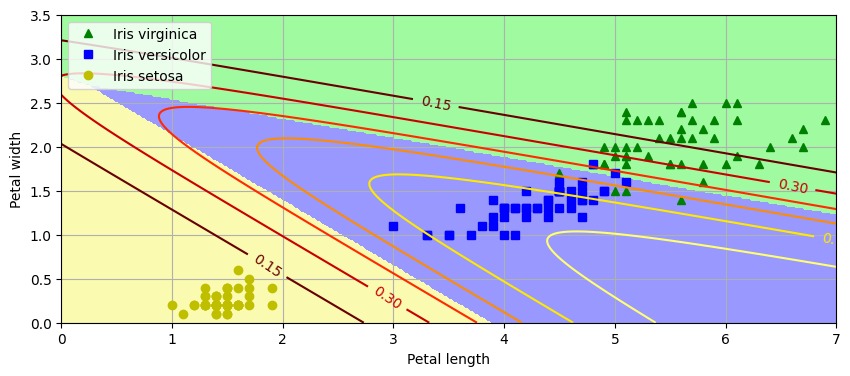

In [ ]:
import matplotlib as mpl

custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

# Create equally spaced x and y axis, x0 and x1
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

# calculate their probability and classes
logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

# zz1 will be used to graph the contour lines for y = 1
# aka Iris versicolor
zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
# plot the classes
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

# fill in areas with color based on the  y_predict values
plt.contourf(x0, x1, zz, cmap=custom_cmap)

# draw the countour lines
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [510]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

np.float64(0.9666666666666667)